This notebook provides examples of how to call the hyperconvo functions from Convokit and perform analyses similar to the ones presented in the corresponding paper (http://www.cs.cornell.edu/~cristian/Patterns_of_participant_interactions.html), which describes the hypergraph methodology for modeling and analyzing online public discussions.

Note that due to limitations in what data we can access and distribute, the beta version of the hypergraph methodology presented here currently supports less functionality:

* Instead of Facebook data, we release a dataset of discussions from Reddit (the 1000 most recent threads, with at least 10 comments, from 100 highly active subreddits -- more details in the corresponding readme here: https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/tree/master/datasets/reddit-corpus). For demonstration purposes, we here use a small subset of this dataset ("reddit-corpus-small") containing 100 threads per subreddit.
* Since Reddit does not provide information on who reacted to (i.e., upvoted) each comment, we are presently unable to support reaction-edges in the hypergraph. As such, we can only compute features over in/outdegree distributions of _reply_-edges, and the feature set derived from motifs in the hypergraph is limited to counts and binary indicators or whether or not a motif is present. We will work  towards supporting reactions as well.

In [1]:
import os
os.getcwd()
os.chdir("..")
os.chdir("..")
os.getcwd()

'/Users/calebchiam/Documents/GitHub/Cornell-Conversational-Analysis-Toolkit'

In [2]:
reddit_corpus_dir = "/sauna/reddit_201810_raw/reddit-corpus-2/reddit-corpus"

In [3]:
import convokit

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

First we download the reddit corpus:

In [10]:
# corpus = convokit.Corpus(filename=os.path.join(reddit_corpus_dir, 'reddit-corpus'))
corpus = convokit.Corpus(filename=convokit.download('reddit-corpus'))

Dataset already exists at /Users/calebchiam/.convokit/downloads/reddit-corpus


In [7]:
hc = convokit.HyperConvo(prefix_len=10, min_thread_len=10, include_root=False)

In [195]:
path_stats = hc.retrieve_motif_pathway_stats(corpus)

path_stats_df = pd.DataFrame.from_dict(path_stats, orient='index')
columns = ['PATH-'+', '.join(filter(lambda x: type(x) == str, col)).strip() for col in path_stats_df.columns.values]
path_stats_df.columns = columns

path_stats_enum_df = pd.DataFrame()

for path_stat in columns:
    path_stats_enum_df['is-present[{}]'.format(path_stat)] = path_stats_df[path_stat] > 0
    path_stats_enum_df['count[{}]'.format(path_stat)] = path_stats_df[path_stat]

path_feat_names = list(path_stats_enum_df.columns)

In [128]:
motif_counts = hc.retrieve_feats(corpus)

In [129]:
motif_counts_df = pd.DataFrame.from_dict(motif_counts, orient='index')
motif_feat_names = list(motif_counts_df.columns)

In [206]:
# feat_df = pd.concat([path_stats_enum_df, motif_counts_df], axis=1)
# feat_df = pd.concat([motif_counts_df, path_stats_df], axis=1)
feat_df = path_stats_enum_df

In [197]:
feat_df.shape

(100000, 100)

In [53]:
# for thread_id, motif_path_stats_dict in motif_path_stats.items():
#     for motif_path, val in motif_path_stats_dict.items():
#         feat_df.loc[thread_id][motif_path] = val

In [198]:
from sklearn.preprocessing import Imputer, Normalizer, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [208]:
feat_mtx = Imputer(axis=1, missing_values=-1).fit_transform(feat_df.values)
feat_mtx = StandardScaler().fit_transform(feat_mtx)

In [209]:
svd = TruncatedSVD(n_components=7, algorithm='arpack') # deals with an issue where the randomized alg hangs
svd.fit(feat_mtx)
U, s, V = svd.transform(feat_mtx) / svd.singular_values_, \
        svd.singular_values_, \
        svd.components_.T

In [210]:
U_norm = Normalizer().fit_transform(U)
V_norm = Normalizer().fit_transform(V)
U_df = pd.DataFrame(data=U_norm, index=feat_df.index)
V_df = pd.DataFrame(data=V_norm, index=path_feat_names)

As in the paper, for further interpretability we can consider embeddings of _communities_ (subreddits, standing for Facebook pages) in terms of the discussions they foster, by averaging the embeddings of all threads in a particular subreddit.

In [60]:
threads = corpus.utterance_threads(prefix_len=10, include_root=False)

In [61]:
def get_subreddit(threads, thread_id):
    return threads[thread_id][thread_id].meta["subreddit"]

In [211]:
# subreddits = [get_subreddit(threads, thread_id) for thread_id in threads]
U_df['subreddit'] = list(pd.Series(U_df.index).apply(lambda x: get_subreddit(threads, x)))

In [212]:
subreddit_means = U_df.groupby('subreddit').mean()
subreddit_df = pd.DataFrame(
        data=Normalizer().fit_transform(subreddit_means.values),
        index = subreddit_means.index
    )

First, let's give a rough overview of the space we've sketched out through this procedure, by visualizing the subreddit embeddings using the TSNE algorithm.

In [213]:
tsne = TSNE(random_state=2018)
tsne_df = pd.DataFrame(data=tsne.fit_transform(subreddit_df.values),
                      index=subreddit_df.index)

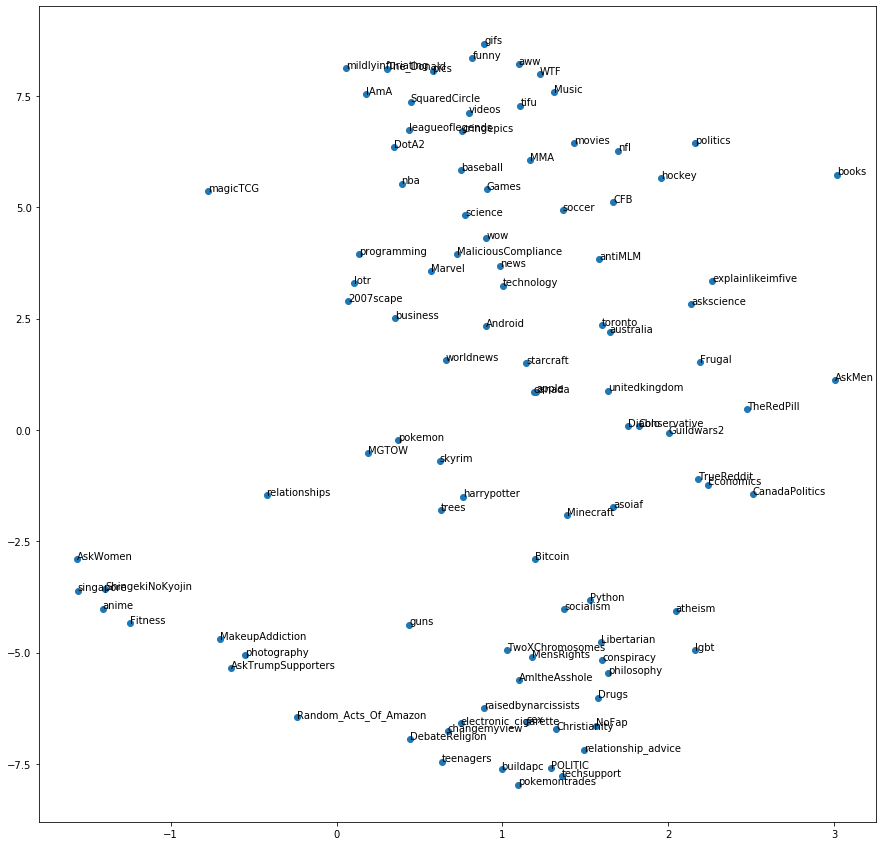

In [216]:
plt.figure(figsize=(15,15))
plt.scatter(tsne_df[0].values, tsne_df[1].values)
for i, txt in enumerate(tsne_df.index):
    plt.annotate(txt, (tsne_df.values[i,0], tsne_df.values[i,1]))
plt.show()

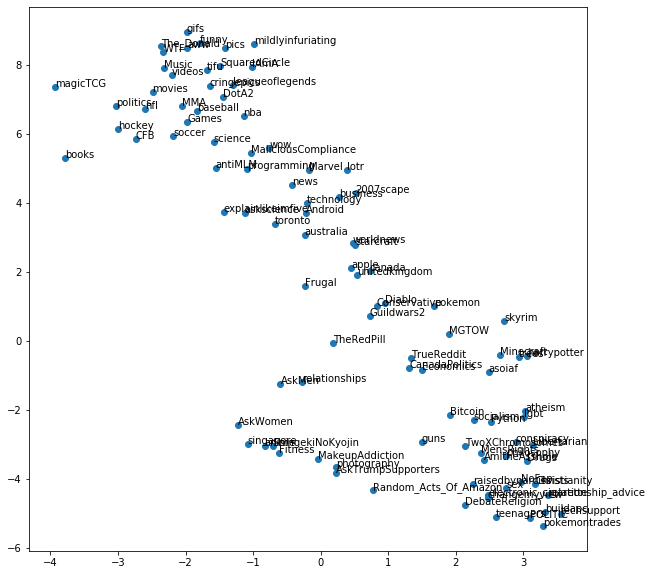

In [193]:
plt.figure(figsize=(10,10))
plt.scatter(tsne_df[0].values, tsne_df[1].values)
for i, txt in enumerate(tsne_df.index):
    plt.annotate(txt, (tsne_df.values[i,0], tsne_df.values[i,1]))
plt.show()

Looking across this plot, we can spot a few interpretable-looking groupings:

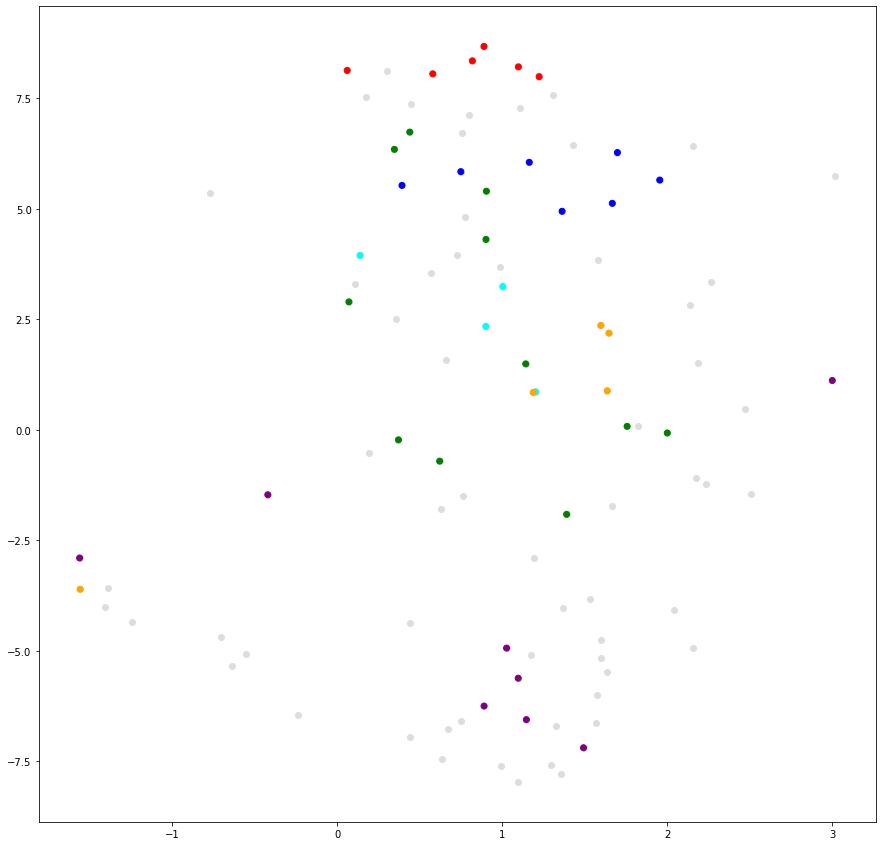

In [219]:
plt.figure(figsize=(15,15))
games = ["Guildwars2", "2007scape", "skyrim", "wow", "pokemon", "DotA2", "starcraft", "Diablo", "leagueoflegends", "Minecraft", "Games"]
sports = ["baseball", "CFB", "hockey", "MMA", "nba", "nfl", "soccer"]
tech = ["Android", "apple", "technology", "programming"]
reaction_bait = ["WTF", "pics", "gifs", "aww", "funny", "todayilearned", "AdviceAnimals", "mildlyinfuriating"]
relationships = ["TwoXChromosomes", "AskMen", "AskWomen", "sex", "AmItheAsshole", "relationships", "raisedbynarcissists", "relationship_advice"]
countries = ["singapore", "canada", "unitedkingdom", "australia", "toronto"]
plt.scatter(tsne_df[0].values, tsne_df[1].values, color="#dddddd")
plt.scatter(tsne_df[0].values, tsne_df[1].values, color=[
    "green" if l in games else
    "cyan" if l in tech else
    "purple" if l in relationships else
    "red" if l in reaction_bait else
    "blue" if l in sports else
    "orange" if l in countries else
    "#00000000"
    for l in tsne_df.index])
plt.show()

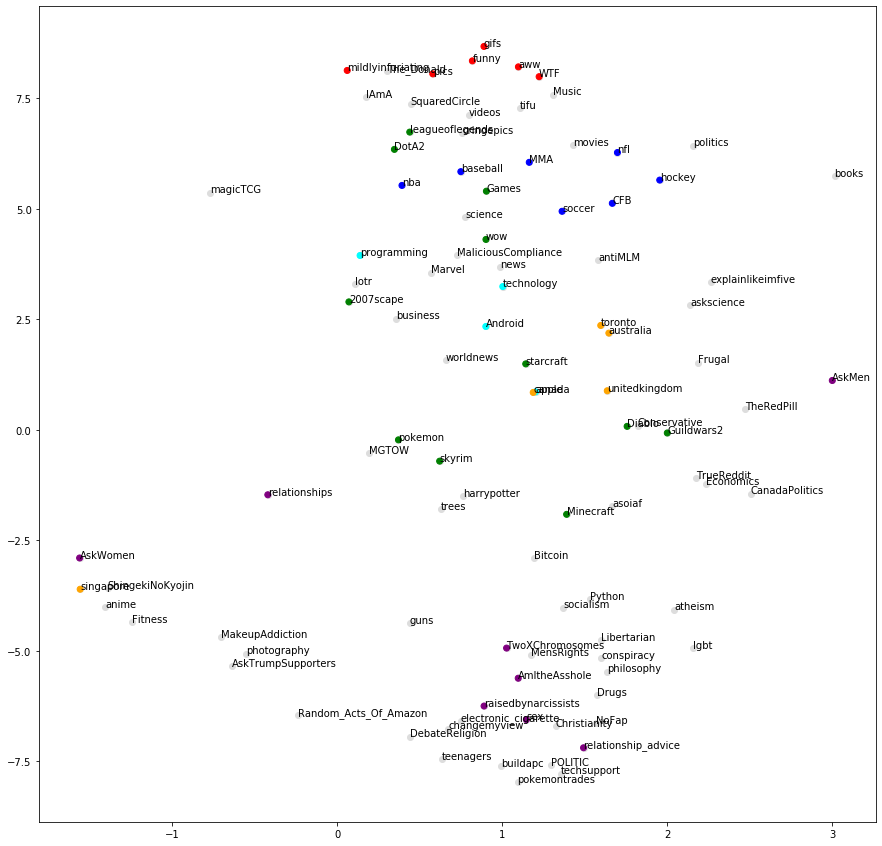

In [218]:
plt.figure(figsize=(15,15))
games = ["Guildwars2", "2007scape", "skyrim", "wow", "pokemon", "DotA2", "starcraft", "Diablo", "leagueoflegends", "Minecraft", "Games"]
sports = ["baseball", "CFB", "hockey", "MMA", "nba", "nfl", "soccer"]
tech = ["Android", "apple", "technology", "programming"]
reaction_bait = ["WTF", "pics", "gifs", "aww", "funny", "todayilearned", "AdviceAnimals", "mildlyinfuriating"]
relationships = ["TwoXChromosomes", "AskMen", "AskWomen", "sex", "AmItheAsshole", "relationships", "raisedbynarcissists", "relationship_advice"]
countries = ["singapore", "canada", "unitedkingdom", "australia", "toronto"]
plt.scatter(tsne_df[0].values, tsne_df[1].values, color="#dddddd")
plt.scatter(tsne_df[0].values, tsne_df[1].values, color=[
    "green" if l in games else
    "cyan" if l in tech else
    "purple" if l in relationships else
    "red" if l in reaction_bait else
    "blue" if l in sports else
    "orange" if l in countries else
    "#00000000"
    for l in tsne_df.index])
for i, txt in enumerate(tsne_df.index):
    plt.annotate(txt, (tsne_df.values[i,0], tsne_df.values[i,1]))
plt.show()

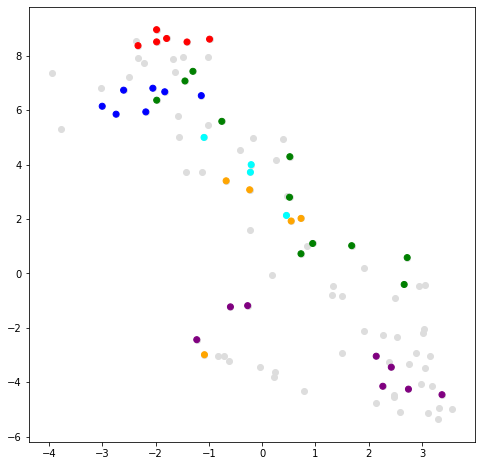

In [194]:
plt.figure(figsize=(8,8))
games = ["Guildwars2", "2007scape", "skyrim", "wow", "pokemon", "DotA2", "starcraft", "Diablo", "leagueoflegends", "Minecraft", "Games"]
sports = ["baseball", "CFB", "hockey", "MMA", "nba", "nfl", "soccer"]
tech = ["Android", "apple", "technology", "programming"]
reaction_bait = ["WTF", "pics", "gifs", "aww", "funny", "todayilearned", "AdviceAnimals", "mildlyinfuriating"]
relationships = ["TwoXChromosomes", "AskMen", "AskWomen", "sex", "AmItheAsshole", "relationships", "raisedbynarcissists", "relationship_advice"]
countries = ["singapore", "canada", "unitedkingdom", "australia", "toronto"]
plt.scatter(tsne_df[0].values, tsne_df[1].values, color="#dddddd")
plt.scatter(tsne_df[0].values, tsne_df[1].values, color=[
    "green" if l in games else
    "cyan" if l in tech else
    "purple" if l in relationships else
    "red" if l in reaction_bait else
    "blue" if l in sports else
    "orange" if l in countries else
    "#00000000"
    for l in tsne_df.index])
plt.show()

Some observations: it's interesting that two of the gaming subreddits (green points): leagueoflegends and Games, lie so close to the rest of the sports (blue points). Perhaps because of e-sports status?

the_donald (cyan) lies close to the rest of the reaction-bait subreddits.

For instance, video games (e.g., tf2, DotA2; red) tend to group together, along with buy-sell subreddits (e.g., tf2trade, Dota2Trade, yellow), subreddits related to relationships (e.g., AskWomen, relationship_advice; green) and large default-subreddit hubs for sharing random links (e.g., pics, AskReddit; purple).

There may be other interesting groupings that you may spot as well -- for instance, a vaguely right-wing MensRights cluster (with Libertarian, guns); a rather intriguing cluster consisting of politics, sex, business, etc.

Some topical groups are more diffuse -- for instance, sports-based subreddits (blue). Perhaps this is a limitation of our representation, or that these subreddits actually foster very different interactional dynamics.

Another way to delve into these groupings is to look at nearest neighbors of subreddits, in terms of the embedding:

In [67]:
dists = pairwise_distances(subreddit_df.values, metric='cosine')
flat_dists = np.ravel(dists)
idx1, idx2 = np.unravel_index(np.arange(len(flat_dists)), dists.shape)
pairwise_dist_df = pd.DataFrame.from_dict({'p1': subreddit_df.index[idx1],
                                           'p2': subreddit_df.index[idx2],
                                           'dist': flat_dists},
                                           orient='columns')

In [68]:
def print_nearest_neighbors(pairwise_dist_df, 
                           test_subreddits=[],
                           top_N=10):
    for subreddit in test_subreddits:
        subset_df = pairwise_dist_df[(pairwise_dist_df.p1 == subreddit)
                                 & (pairwise_dist_df.p2 != subreddit)]
        print(subreddit)
        print(subset_df.sort_values('dist')[['p2', 'dist']].head(top_N))
        print()

In [69]:
print_nearest_neighbors(pairwise_dist_df, ['apple', 'politics', 'leagueoflegends',
                                          'AskWomen', 'Music', 'pics',
                                          'australia', 'Random_Acts_Of_Amazon',
                                          'Bitcoin', 'MensRights'])

apple
                    p2      dist
4334  ShingekiNoKyojin  0.007810
4374       photography  0.013342
4384               sex  0.013844
4312            Diablo  0.015030
4390        technology  0.016497
4372               nfl  0.017076
4378          politics  0.017524
4349          baseball  0.020062
4345            asoiaf  0.020743
4335     SquaredCircle  0.021397

politics
                     p2      dist
7889          starcraft  0.011122
7843              apple  0.017524
7831            POLITIC  0.021504
7868  mildlyinfuriating  0.023529
7837         The_Donald  0.025165
7834   ShingekiNoKyojin  0.026783
7816            Fitness  0.028858
7896      unitedkingdom  0.030102
7874        photography  0.031593
7849           baseball  0.031889

leagueoflegends
                      p2      dist
6440                 WTF  0.008029
6404  AskTrumpSupporters  0.010221
6424     MakeupAddiction  0.022225
6446             atheism  0.022720
6451            buildapc  0.024175
6469              mo

We can also try to interpret each dimension of the embedding -- roughly speaking the threads, features and subreddits with extremal values along one dimension could be seen as characterizing a particular "type" of discussion, in terms of the discussion structure.

In [31]:
from IPython.display import display

In [32]:
def display_dimension(dim, ascending=True, n=5):
    top_threads = U_df.sort_values(dim, ascending=ascending).head(n)
    display(top_threads)
    display(V_df.sort_values(dim, ascending=ascending).head(n))
    display(subreddit_df.sort_values(dim, ascending=ascending).head(n))
    return top_threads.index

For instance, the first latent dimension divides the space of Reddit discussions between focused dialogues involving 2 people who repeatedly interact, and "expansionary" threads involving multiple people who generally only engage once (as with the corresponding dimension discussed in the paper, this echoes the contrast explored in papers such as Backstrom et. al, 2013). At the subreddit level, we see a divide between subreddits that are selling things (perhaps the dialogues consist of a buyer and a seller) and large default link-sharing subreddits like AskReddit and pics.

In [ ]:
top_threads = display_dimension(0, n=10)